<a href="https://colab.research.google.com/github/stevejj4/Insurance-data-lifecycle/blob/main/Interactions_EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [36]:
#!pip install google-cloud-bigquery
#!pip install pyspark==3.1.2

from google.colab import auth
auth.authenticate_user()

from google.cloud import bigquery
import pandas as pd
from pyspark.sql import SparkSession


In [37]:
# Authenticating and initializing BigQuery client
project_id = 'river-messenger-430112-e1'
client = bigquery.Client(project=project_id)

In [38]:
# Querying to get interactions table
query_interactions = """
SELECT * FROM `river-messenger-430112-e1.Insurance_data.interactions`;
"""

In [39]:
# Executing the query and converting to a pandas DataFrame
df_interactions = client.query(query_interactions).to_dataframe()

In [40]:
# Displaying the first few rows of the pandas DataFrame
#print(df_interactions.head())

In [41]:
# Initializing SparkSession
spark = SparkSession.builder \
    .appName('BigQuerySparkApp') \
    .getOrCreate()

# Converting pandas DataFrame to Spark DataFrame
# Using iterrows() instead of iteritems() to iterate over DataFrame rows
spark_df_interactions = spark.createDataFrame(df_interactions.to_dict('records'))

# Show the schema and first few rows
spark_df_interactions.printSchema()
#spark_df_interactions.show(5)

root
 |-- CustomerID: long (nullable = true)
 |-- InteractionDate: string (nullable = true)
 |-- InteractionID: long (nullable = true)
 |-- InteractionOutcome: string (nullable = true)
 |-- InteractionType: string (nullable = true)



In [42]:
from pyspark.sql.functions import col, when

# Handling missing values
# For example, fill missing InteractionOutcome with 'not resolved'
spark_df_interactions = spark_df_interactions.fillna({'InteractionOutcome': 'not resolved'})

# Display the updated DataFrame
spark_df_interactions.show(5)


+----------+---------------+-------------+------------------+---------------+
|CustomerID|InteractionDate|InteractionID|InteractionOutcome|InteractionType|
+----------+---------------+-------------+------------------+---------------+
|      1599|     2023-07-19|          518|        Unresolved|           Call|
|       488|     2023-07-19|          678|          Resolved|           Call|
|      1942|     2023-07-19|          717|          Resolved|           Call|
|      1065|     2023-07-19|          822|        Unresolved|           Call|
|       988|     2023-07-19|         3839|        Unresolved|           Call|
+----------+---------------+-------------+------------------+---------------+
only showing top 5 rows



In [43]:
# Creating a satisfaction score feature
spark_df_interactions = spark_df_interactions.withColumn(
    'SatisfactionScore', when(col('InteractionOutcome') == 'resolved', 1).otherwise(0)
)

# Extract year, month, day from InteractionDate
from pyspark.sql.functions import year, month, dayofmonth

spark_df_interactions = spark_df_interactions.withColumn('Year', year(col('InteractionDate')))
spark_df_interactions = spark_df_interactions.withColumn('Month', month(col('InteractionDate')))
spark_df_interactions = spark_df_interactions.withColumn('Day', dayofmonth(col('InteractionDate')))

# Display the updated DataFrame with new features
spark_df_interactions.show(5)


+----------+---------------+-------------+------------------+---------------+-----------------+----+-----+---+
|CustomerID|InteractionDate|InteractionID|InteractionOutcome|InteractionType|SatisfactionScore|Year|Month|Day|
+----------+---------------+-------------+------------------+---------------+-----------------+----+-----+---+
|      1599|     2023-07-19|          518|        Unresolved|           Call|                0|2023|    7| 19|
|       488|     2023-07-19|          678|          Resolved|           Call|                0|2023|    7| 19|
|      1942|     2023-07-19|          717|          Resolved|           Call|                0|2023|    7| 19|
|      1065|     2023-07-19|          822|        Unresolved|           Call|                0|2023|    7| 19|
|       988|     2023-07-19|         3839|        Unresolved|           Call|                0|2023|    7| 19|
+----------+---------------+-------------+------------------+---------------+-----------------+----+-----+---+
o

In [44]:
# Number of interactions per day
interactions_per_day = spark_df_interactions.groupBy('Year', 'Month', 'Day').count()
interactions_per_day.show(5)

# Number of resolved and not resolved interactions
interaction_outcomes = spark_df_interactions.groupBy('InteractionOutcome').count()
interaction_outcomes.show(5)

# Number of interactions per interaction type
interactions_per_type = spark_df_interactions.groupBy('InteractionType').count()
interactions_per_type.show(5)

# Number of interactions per customer
interactions_per_customer = spark_df_interactions.groupBy('CustomerID').count()
interactions_per_customer.show(5)


+----+-----+---+-----+
|Year|Month|Day|count|
+----+-----+---+-----+
|2024|    3| 19|   13|
|2024|    2| 10|   11|
|2024|    1| 13|   14|
|2023|    9|  4|   20|
|2023|    8| 10|   14|
+----+-----+---+-----+
only showing top 5 rows

+------------------+-----+
|InteractionOutcome|count|
+------------------+-----+
|        Unresolved| 2497|
|          Resolved| 2503|
+------------------+-----+

+---------------+-----+
|InteractionType|count|
+---------------+-----+
|           Call| 1642|
|          Email| 1677|
|          Visit| 1681|
+---------------+-----+

+----------+-----+
|CustomerID|count|
+----------+-----+
|        26|    3|
|        29|    2|
|      1950|    3|
|      1806|    4|
|       964|    1|
+----------+-----+
only showing top 5 rows



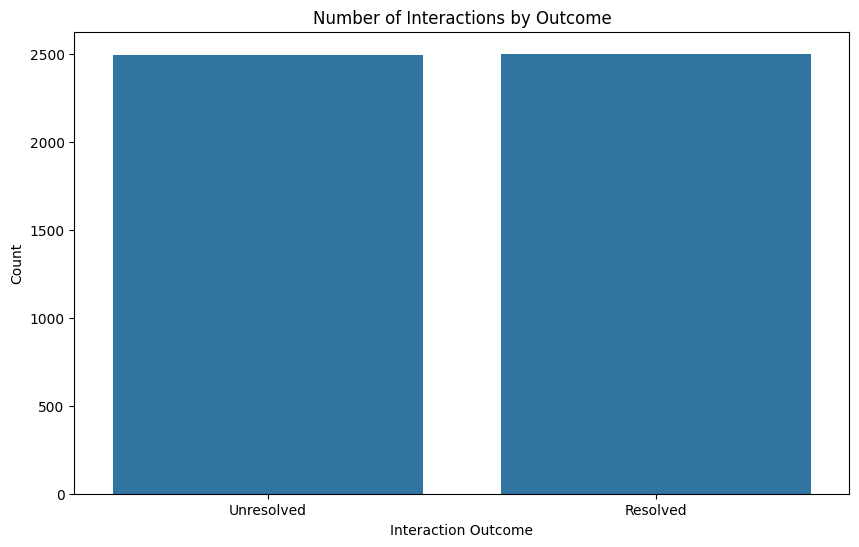

In [45]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot interaction outcomes
plt.figure(figsize=(10, 6))
sns.barplot(x='InteractionOutcome', y='count', data=pdf_interaction_outcomes)
plt.title('Number of Interactions by Outcome')
plt.xlabel('Interaction Outcome')
plt.ylabel('Count')
plt.show()


In [46]:
import torch
from torch import nn, optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Converting Spark DataFrame to Pandas DataFrame for processing with PyTorch
df_interactions = spark_df_interactions.toPandas()

# Selecting features and target
features = df_interactions[['InteractionType', 'Year', 'Month', 'Day']]
target = df_interactions['SatisfactionScore']

# One-hot encode categorical features and standardize numerical features
features = pd.get_dummies(features, columns=['InteractionType'])
scaler = StandardScaler()
features = scaler.fit_transform(features)

# Spliting data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

# Converting data to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_train = torch.tensor(y_train.values, dtype=torch.float32)
y_test = torch.tensor(y_test.values, dtype=torch.float32)

# Defining the model architecture
class InteractionModel(nn.Module):
    def __init__(self):
        super(InteractionModel, self).__init__()
        self.fc1 = nn.Linear(X_train.shape[1], 50)
        self.fc2 = nn.Linear(50, 10)
        self.fc3 = nn.Linear(10, 1)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.sigmoid(self.fc3(x))
        return x

# Initializing the model, loss function, and optimizer
model = InteractionModel()
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training the model
epochs = 100
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    output = model(X_train)
    loss = criterion(output, y_train.unsqueeze(1))
    loss.backward()
    optimizer.step()

    if (epoch+1) % 10 == 0:
        print(f'Epoch {epoch+1}/{epochs}, Loss: {loss.item()}')

# Evaluate the model
model.eval()
with torch.no_grad():
    predictions = model(X_test)
    accuracy = ((predictions.squeeze() > 0.5) == y_test).float().mean()
    print(f'Accuracy: {accuracy.item() * 100:.2f}%')


Epoch 10/100, Loss: 0.7623012065887451
Epoch 20/100, Loss: 0.6755478382110596
Epoch 30/100, Loss: 0.5653389692306519
Epoch 40/100, Loss: 0.43958455324172974
Epoch 50/100, Loss: 0.3167325258255005
Epoch 60/100, Loss: 0.21423062682151794
Epoch 70/100, Loss: 0.13979315757751465
Epoch 80/100, Loss: 0.09122921526432037
Epoch 90/100, Loss: 0.061394546180963516
Epoch 100/100, Loss: 0.04325856640934944
Accuracy: 100.00%
